# Import Libraries, create constants and functions

## Libraries

In [317]:
!pip install numba=="0.57.1"
!pip install tsfresh
!pip install stock_predict_lib
import json
import yfinance as yf
import datetime
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tsfresh import extract_relevant_features, extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

END_DATE = datetime.datetime.now()
START_DATE = END_DATE - datetime.timedelta(days=5 * 365)
ESG_QUERY = 'https://query2.finance.yahoo.com/v1/finance/esgChart?symbol='
SYMBOLS = {
    'AMZN': 0,
    'AAPL': 1,
    'XOM': 2,
    'NKE': 3,
    'PFE': 4,
    'TSLA': 5
    }

ERROR: Could not find a version that satisfies the requirement stock_predict_lib (from versions: none)
ERROR: No matching distribution found for stock_predict_lib


## Functions

### Get Price Data and ESG Scores

In [318]:
def get_data():
  df = pd.read_csv('/content/esg.csv')
  for symbol in SYMBOLS:
    new_df = df[df['Symbol'] == symbol]
    new_df.interpolate(limit_direction="both",inplace=True)
    df[df['Symbol'] == symbol] = new_df

  return df

# Data Preparation and Visualization

## Getting the data

In [319]:
df = get_data()
df['Symbol'] = df['Symbol'].replace(SYMBOLS)
df

<ipython-input-318-a51d84b83d56>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.interpolate(limit_direction="both",inplace=True)


,Symbol,Time,ESG,Governance,Environment,Social,Close
0,1,1504216800,67.190000,57.480000,83.730000,55.20,41.012501
1,1,1506808800,67.400000,52.680000,85.860000,56.80,41.367500
2,1,1509490800,67.400000,52.680000,85.860000,56.80,41.722500
3,1,1512082800,67.400000,52.680000,85.860000,56.80,42.762501
4,1,1514761200,68.540000,52.680000,88.700000,56.80,42.353750
...,...,...,...,...,...,...,...
355,2,1648764000,36.926667,8.140000,18.736667,10.06,83.120003
356,2,1651356000,36.460000,8.140000,18.510000,9.82,90.480000
357,2,1654034400,36.463333,8.126667,18.523333,9.82,97.839996
358,2,1656626400,36.466667,8.113333,18.536667,9.82,87.550003


## Visualizing the original DataFrame

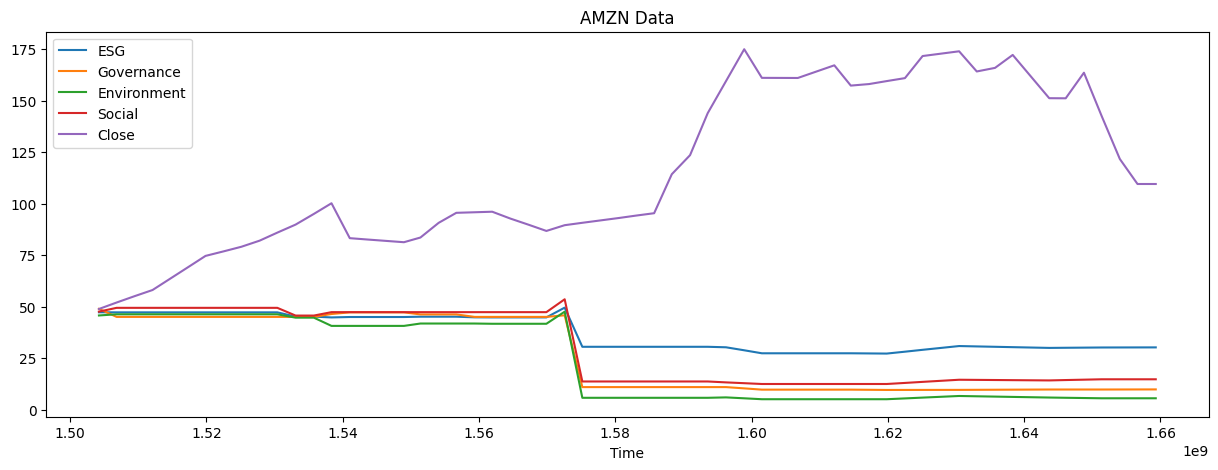

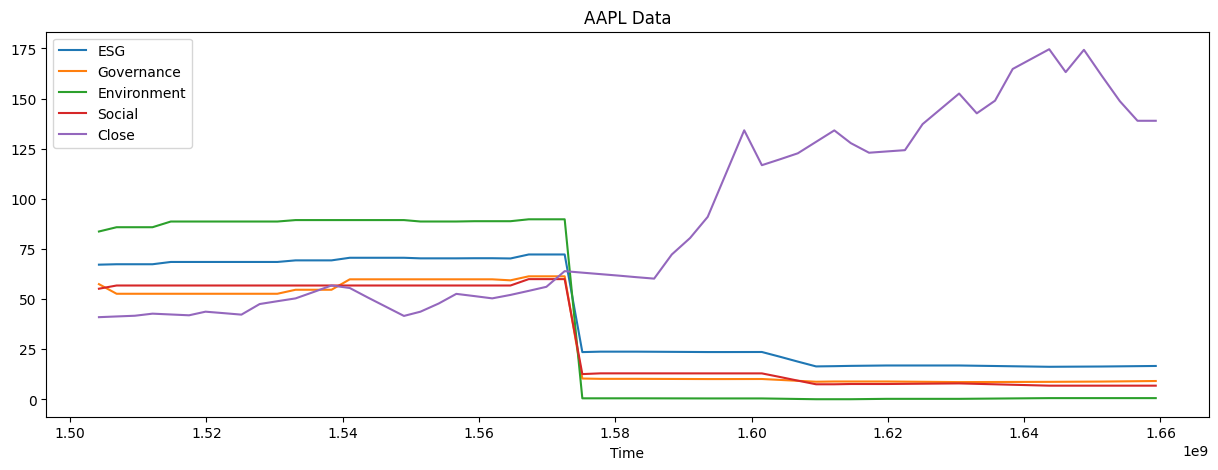

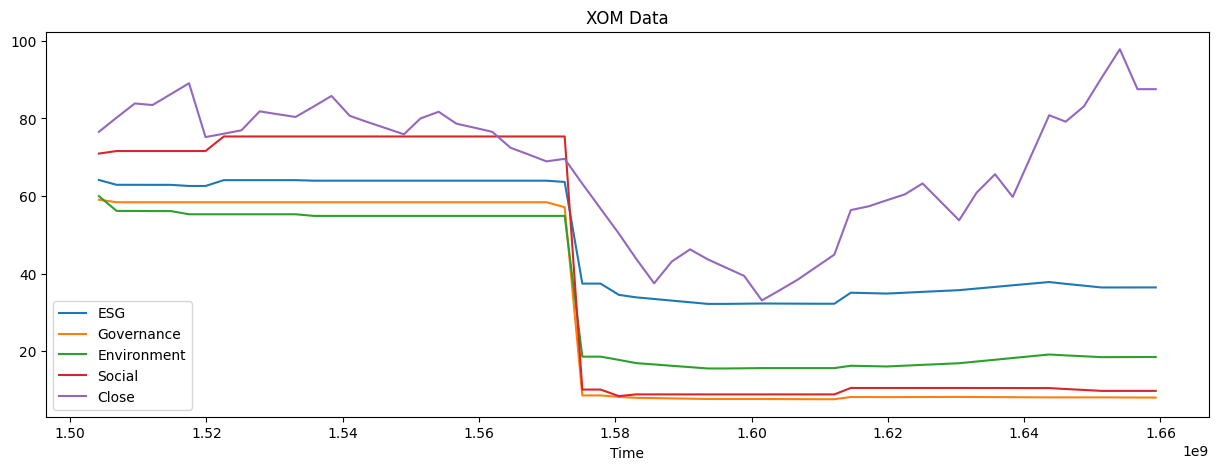

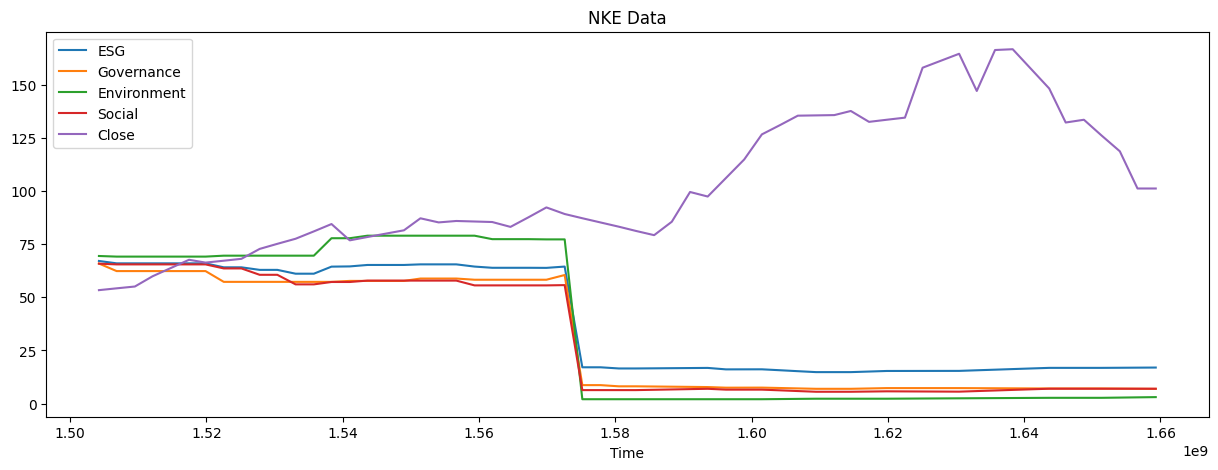

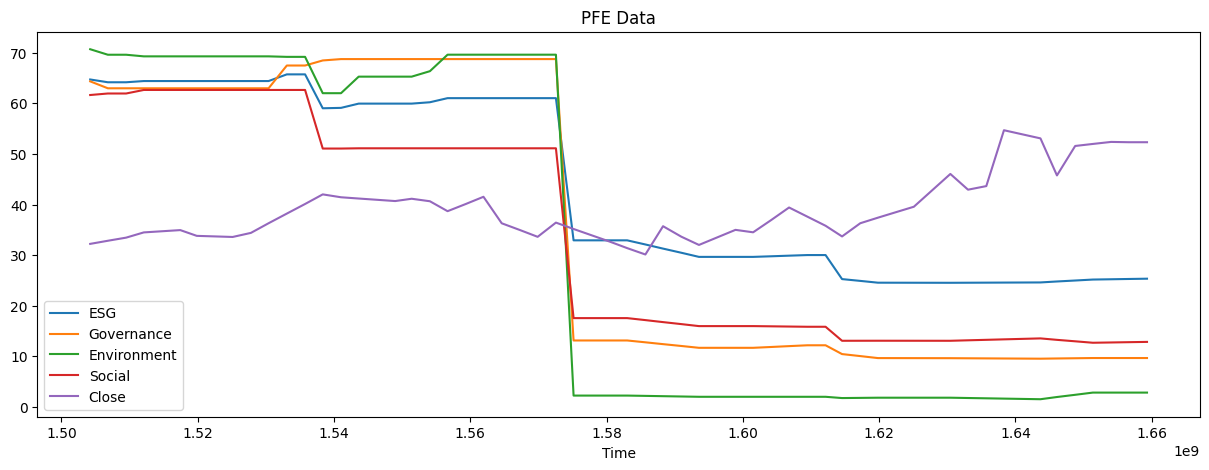

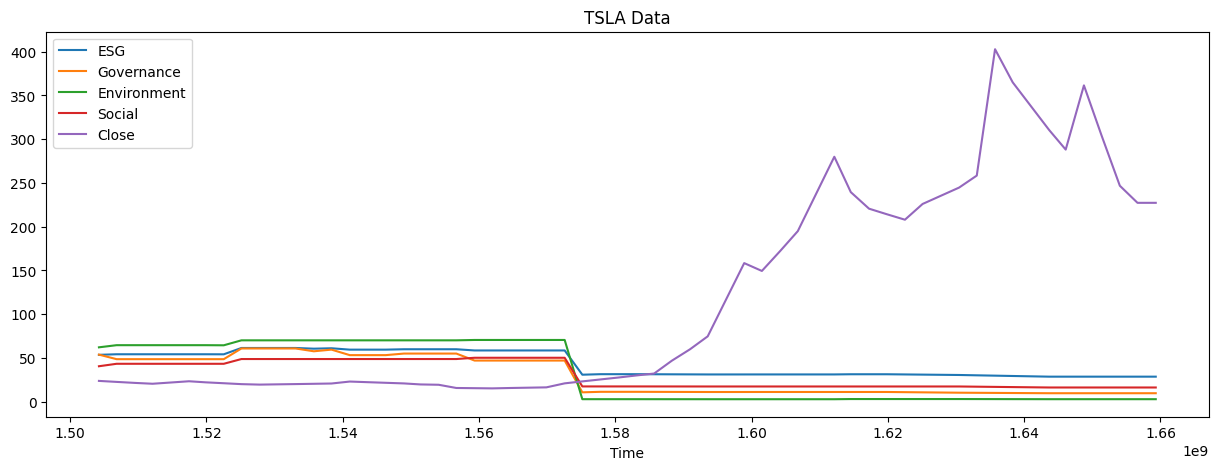

In [320]:
for symbol, value in SYMBOLS.items():
  df[df['Symbol'] == value].drop('Symbol', axis=1).plot(x='Time', figsize=(15, 5), title=f'{symbol} Data')
  plt.show()

## Creating Features and splitting the DataFrame

In [316]:
df_rolled = roll_time_series(df, column_id="Symbol", column_sort="Time")
df_features = extract_features(df_rolled[['ESG', 'Governance', 'Environment', 'Social', 'Close', 'id']], column_id="id", column_sort="id", impute_function=impute)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling:  92%|█████████▏| 55/60 [00:00<00:00, 176.44it/s]/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Feature Extraction: 100%|██████████| 1800/1800 [01:28<00:00, 20.31it/s]


In [321]:
df_copy = df_features.copy()
df_copy['Symbol'] = [i[0] for i in df_copy.index]
df_copy['Time'] = [i[1] for i in df_copy.index]
df_copy.reset_index(inplace=True)
df_copy.drop('level_0', axis=1, inplace=True)
df_copy.drop('level_1', axis=1, inplace=True)
df_copy

,ESG__variance_larger_than_standard_deviation,ESG__has_duplicate_max,ESG__has_duplicate_min,ESG__has_duplicate,ESG__sum_values,ESG__abs_energy,ESG__mean_abs_change,ESG__mean_change,ESG__mean_second_derivative_central,ESG__median,...,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7,Symbol,Time
0,0.0,0.0,0.0,0.0,47.320,2239.182400,1.908192,-0.475256,-0.005435,47.3200,...,1.844550,1.497578,2.250328,2.752287,3.029479,3.127893,0.0,84.772143,0,1504216800
1,0.0,0.0,0.0,0.0,94.600,4474.580800,0.040000,-0.040000,-0.005435,47.3000,...,-0.000000,1.497578,2.250328,2.752287,3.029479,3.127893,0.0,84.772143,0,1506808800
2,0.0,0.0,1.0,1.0,141.880,6709.979200,0.020000,-0.020000,0.020000,47.2800,...,0.693147,-0.000000,2.250328,2.752287,3.029479,3.127893,0.0,84.772143,0,1509490800
3,0.0,0.0,1.0,1.0,189.160,8945.377600,0.013333,-0.013333,0.010000,47.2800,...,1.098612,-0.000000,-0.000000,2.752287,3.029479,3.127893,0.0,84.772143,0,1512082800
4,0.0,0.0,1.0,1.0,236.440,11180.776000,0.010000,-0.010000,0.006667,47.2800,...,1.098612,-0.000000,-0.000000,-0.000000,3.029479,3.127893,0.0,84.772143,0,1514761200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1.0,1.0,1.0,1.0,2455.945,118486.933118,1.879636,-0.453818,0.204907,31.3700,...,1.459622,1.395218,2.156846,2.795511,3.253409,3.518807,0.0,335.082618,5,1648764000
356,1.0,1.0,1.0,1.0,2484.485,119301.464718,1.916071,-0.445714,0.180818,31.3700,...,2.108372,1.386764,2.134555,2.801908,3.339751,3.693848,0.0,338.543092,5,1651356000
357,1.0,1.0,1.0,1.0,2513.025,120115.996318,2.806316,-0.437895,-0.077545,31.3700,...,2.034282,1.381531,2.114247,2.782036,3.370336,3.737968,0.0,338.543092,5,1654034400
358,1.0,1.0,1.0,1.0,2541.565,120930.527918,2.757931,-0.430345,-0.076184,31.3700,...,1.262413,1.478322,2.308051,3.024650,3.522207,3.813353,0.0,338.543092,5,1656626400


In [322]:
y = df[['Close', 'Symbol', 'Time']]
y.index = df_copy.index
X_train, X_test, y_train, y_test = train_test_split(df_copy, y['Close'], test_size=0.2, shuffle=True)

# Predicting Price

## Creating and testing the Model

In [323]:
from tqdm import tqdm
ada = AdaBoostRegressor(DecisionTreeRegressor(min_samples_leaf=7, criterion="squared_error"), n_estimators=20)
ada.fit(df_copy, y['Close'])
# y_pred = ada.predict(df_copy[int(len(df_copy)*0.8):])
y_pred = ada.predict(df_copy[df_copy['Symbol'] == 0])

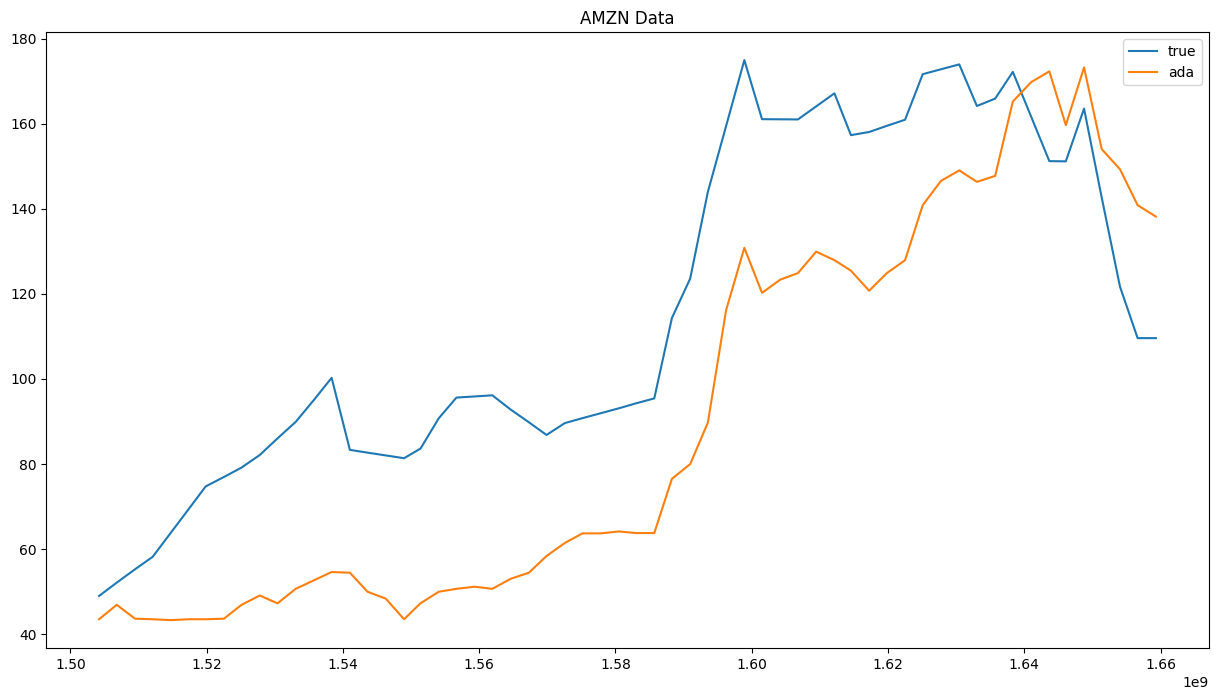

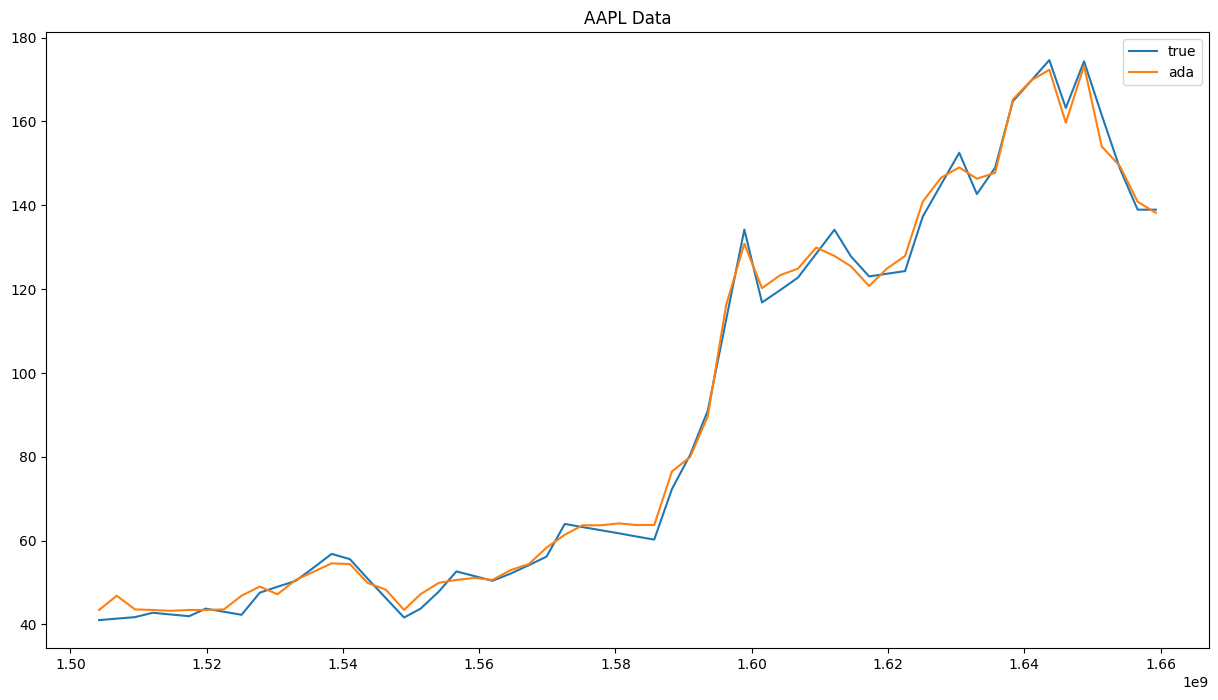

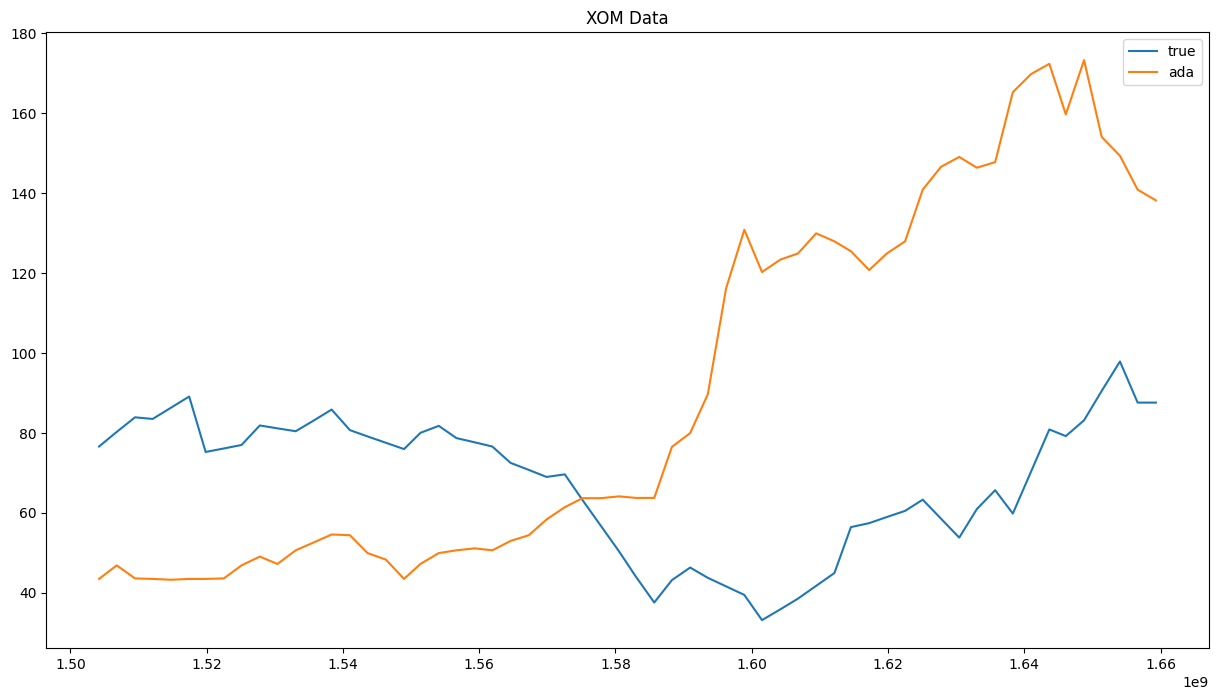

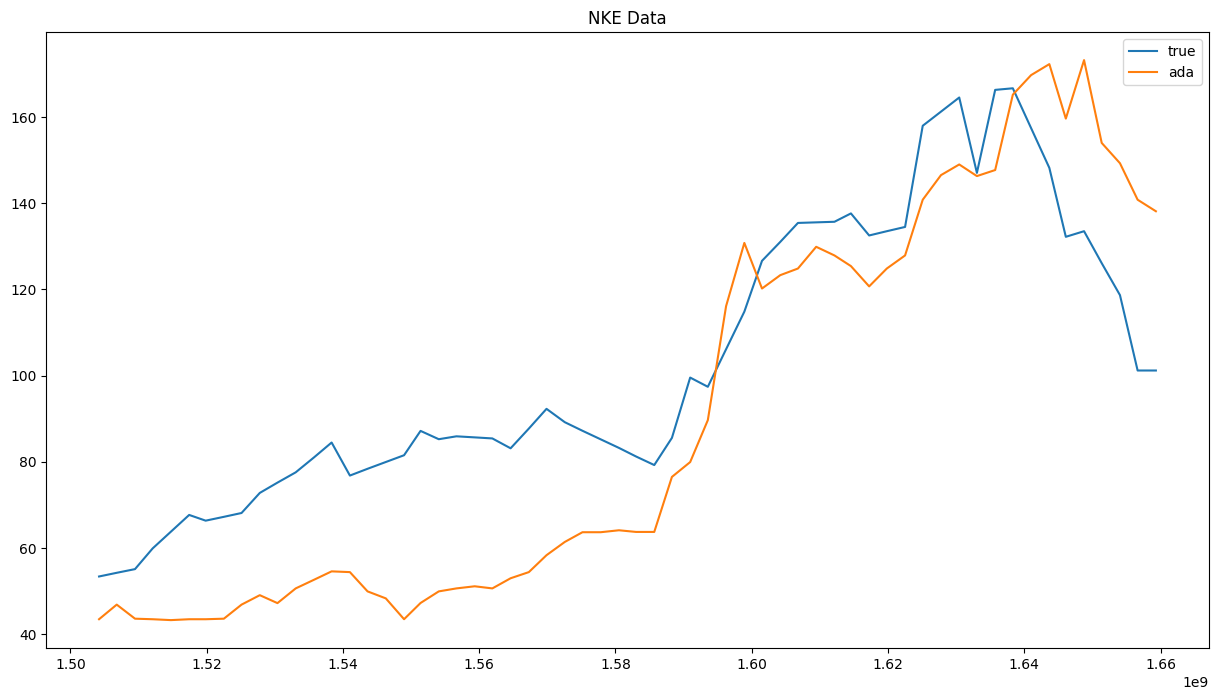

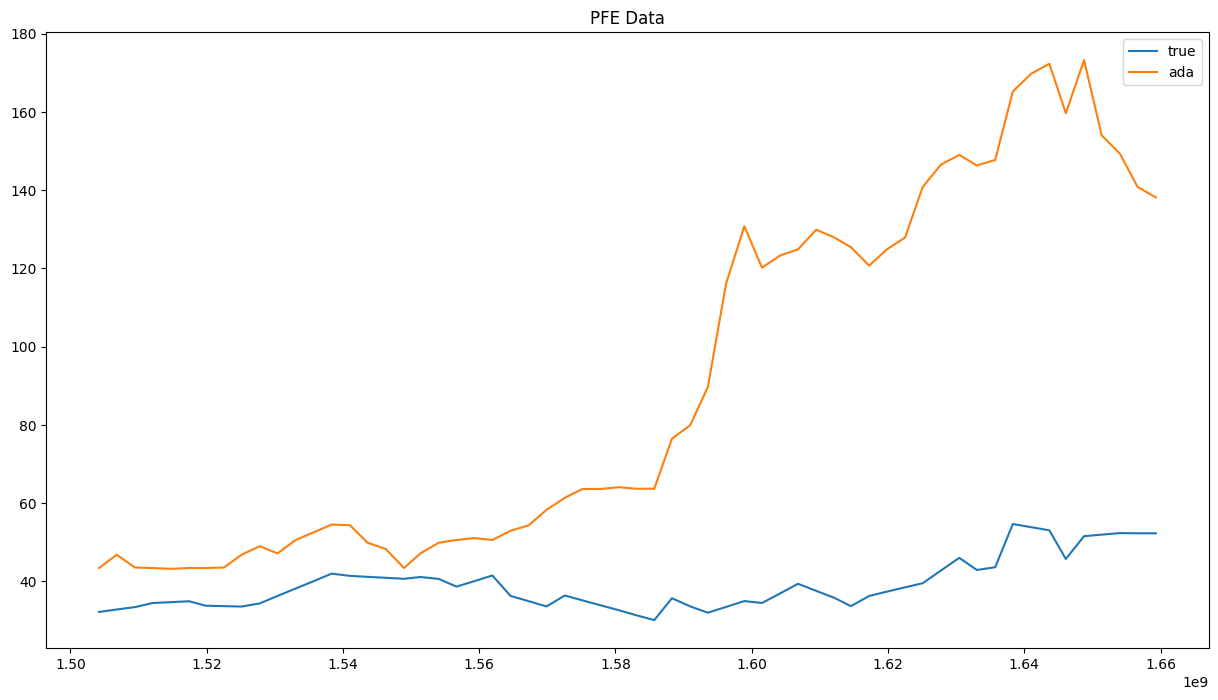

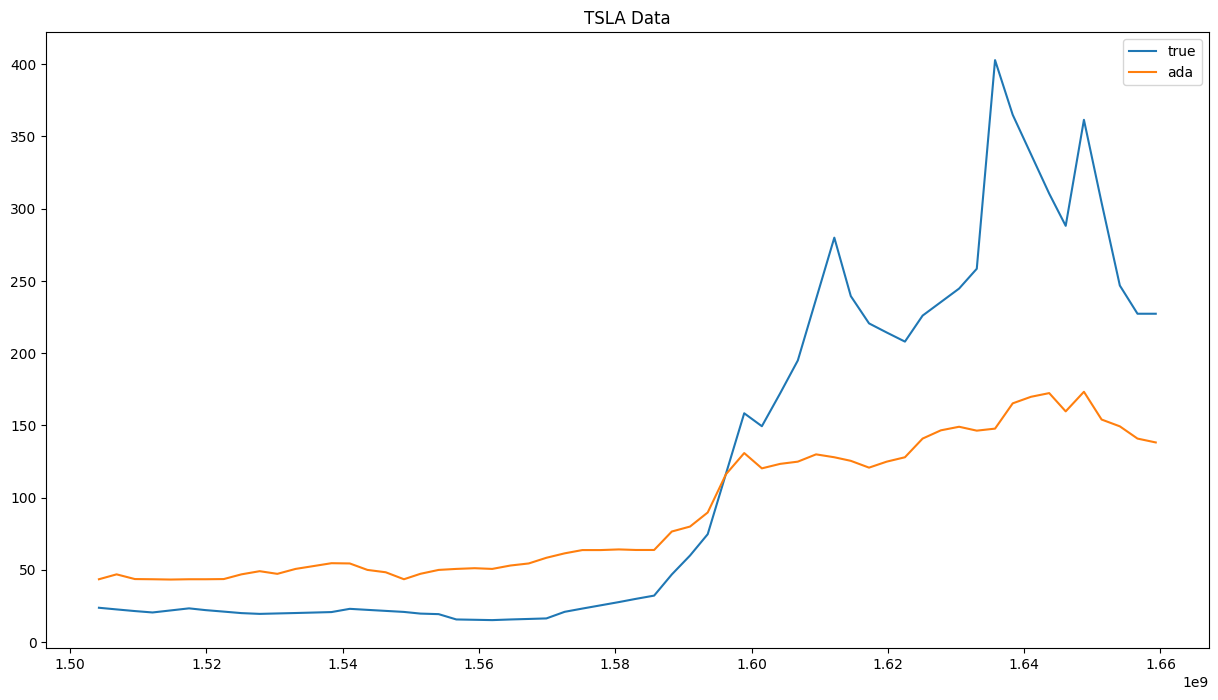

In [324]:
y_pred = pd.Series(data=y_pred, index=df_copy[df_copy['Symbol'] == 0].index)
for symbol, value in SYMBOLS.items():
  data = y[y['Symbol'] == value]
  plt.figure(figsize=(15, 8))
  plt.plot(data['Time'], data['Close'], label="true")
  plt.plot(data['Time'], y_pred, label="ada")
  plt.legend()
  plt.title(f'{symbol} Data')
  plt.show()

In [325]:
importances = pd.Series(index=df_copy.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(15)

Governance__fft_coefficient__attr_"real"__coeff_0                        0.255013
Governance__abs_energy                                                   0.183171
Governance__sum_values                                                   0.146010
Governance__fft_coefficient__attr_"abs"__coeff_0                         0.092390
Social__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"       0.044975
ESG__abs_energy                                                          0.030224
Social__spkt_welch_density__coeff_2                                      0.028226
Social__quantile__q_0.1                                                  0.023048
Governance__quantile__q_0.9                                              0.013557
Governance__sum_of_reoccurring_values                                    0.012703
Close__median                                                            0.011642
Environment__energy_ratio_by_chunks__num_segments_10__segment_focus_5    0.007742
ESG__agg_linear_